In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import glob
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
folder_path = "/content/drive/MyDrive/Colab Notebooks"
files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

data = {}
for file in files:
    instrument_name = file.replace('.csv', '')
    data[instrument_name] = pd.read_csv(os.path.join(folder_path, file))

In [ ]:
for instrument, df in data.items():
    print(f"Columns for {instrument}: {df.columns}")

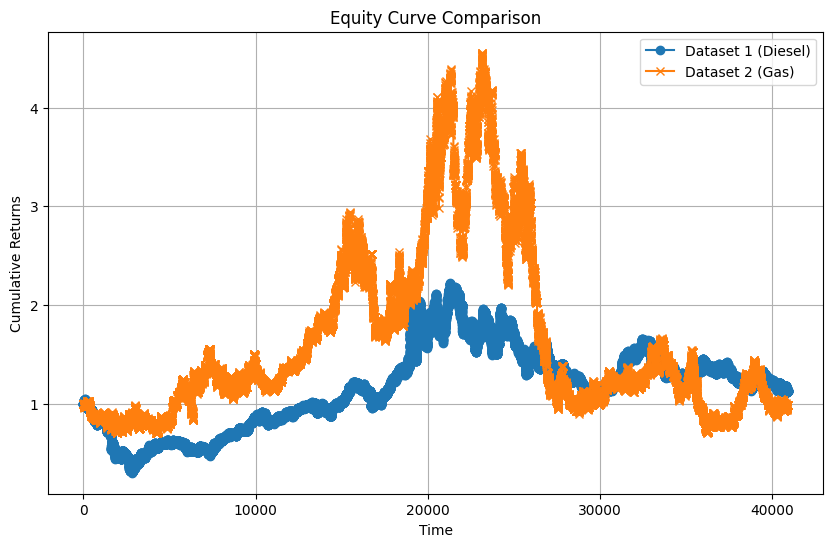

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load datasets from CSV files
data1 = pd.read_csv('/content/DIESEL.CMDUSD_Candlestick_1_Hour_BID_01.01.2020-31.08.2024.csv')
data2 = pd.read_csv('/content/GAS.CMDUSD_Candlestick_1_Hour_BID_01.01.2020-31.08.2024.csv')

# Ensure 'Close' column exists and calculate daily returns
data1['Return'] = data1['Close'].pct_change().fillna(0)
data2['Return'] = data2['Close'].pct_change().fillna(0)

# Compute cumulative returns
data1['Cumulative Return'] = (1 + data1['Return']).cumprod()
data2['Cumulative Return'] = (1 + data2['Return']).cumprod()

# Plot equity curves
plt.figure(figsize=(10, 6))
plt.plot(data1['Cumulative Return'], label='Dataset 1 (Diesel)', marker='o')
plt.plot(data2['Cumulative Return'], label='Dataset 2 (Gas)', marker='x')
plt.title('Equity Curve Comparison')
plt.xlabel('Time')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()



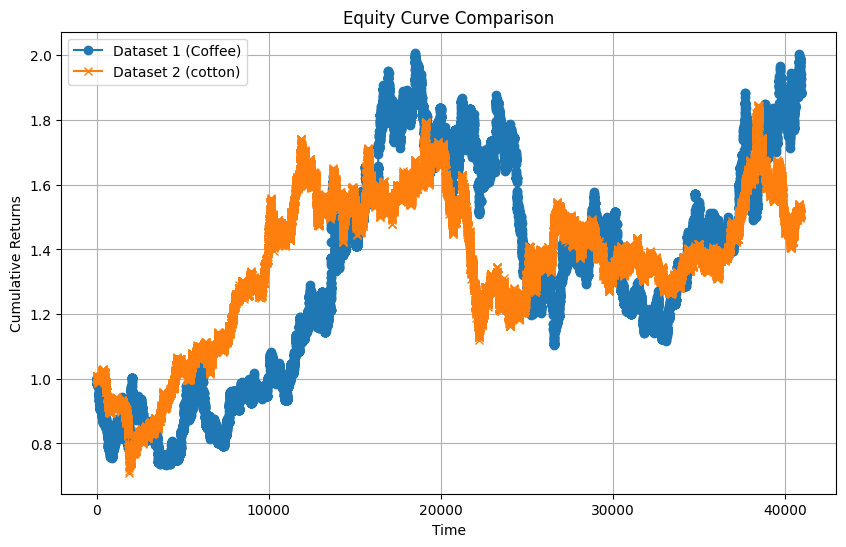

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load datasets from CSV files
data1 = pd.read_csv('/content/COFFEE.CMDUSX_Candlestick_1_Hour_BID_01.01.2020-31.08.2024.csv')
data2 = pd.read_csv('/content/COPPER.CMDUSD_Candlestick_1_Hour_BID_01.01.2020-31.08.2024.csv')

# Ensure 'Close' column exists and calculate daily returns
data1['Return'] = data1['Close'].pct_change().fillna(0)
data2['Return'] = data2['Close'].pct_change().fillna(0)

# Compute cumulative returns
data1['Cumulative Return'] = (1 + data1['Return']).cumprod()
data2['Cumulative Return'] = (1 + data2['Return']).cumprod()

# Plot equity curves
plt.figure(figsize=(10, 6))
plt.plot(data1['Cumulative Return'], label='Dataset 1 (Coffee)', marker='o')
plt.plot(data2['Cumulative Return'], label='Dataset 2 (cotton)', marker='x')
plt.title('Equity Curve Comparison')
plt.xlabel('Time')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()



# Data Cleaning

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score

# Dataset class for PyTorch
class FinancialDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

# Dictionary to store processed data for each instrument
processed_data = {}

# Preprocess data for all instruments
for instrument, df in data.items():
    print(f"Processing instrument: {instrument}")

    # Remove timezone and parse datetime
    df['Local time'] = df['Local time'].str.replace(r' GMT[+-]\d{4}', '', regex=True)
    df['Local time'] = pd.to_datetime(df['Local time'], format='%d.%m.%Y %H:%M:%S.%f')
    df['Hour'] = df['Local time'].dt.hour
    df['Day'] = df['Local time'].dt.day
    df['Month'] = df['Local time'].dt.month
    df['Day_of_Week'] = df['Local time'].dt.dayofweek

    # Drop unused columns
    df.drop(columns=['Local time'], inplace=True)

    # Features and target
    X = df.drop(columns=['Close']).values
    y = df['Close'].values

    # Train-test split
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale the data
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    # Convert to PyTorch tensors
    x_train = torch.tensor(x_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
    x_test = torch.tensor(x_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

    # Create DataLoader
    train_dataset = FinancialDataset(x_train, y_train)
    test_dataset = FinancialDataset(x_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64)

    # Store processed data in dictionary
    processed_data[instrument] = {
        'train_loader': train_loader,
        'test_loader': test_loader,
        'scaler': scaler,
        'input_size': x_train.shape[1]
    }

# Define the model using nn.Sequential
class FinancialModel(nn.Module):
    def __init__(self, input_size, hidden_size1=64, hidden_size2=32):
        super(FinancialModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size1),
            nn.ReLU(),
            nn.Linear(hidden_size1, hidden_size2),
            nn.ReLU(),
            nn.Linear(hidden_size2, 1)  # Single output for regression
        )

    def forward(self, x):
        return self.layers(x)

    @staticmethod
    def loss(y_pred, y):
        return F.mse_loss(y_pred, y)

# Train and evaluate the model for each instrument
for instrument, data in processed_data.items():
    print(f"\nTraining model for instrument: {instrument}")
    train_loader = data['train_loader']
    test_loader = data['test_loader']
    input_size = data['input_size']

    # Initialize model and optimizer
    model = FinancialModel(input_size)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    epochs = 100
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for features, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(features)
            loss = model.loss(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {train_loss / len(train_loader):.4f}")

    # Evaluate the model
    model.eval()
    test_loss = 0.0
    predictions = []
    actuals = []
    with torch.no_grad():
        for features, targets in test_loader:
            outputs = model(features)
            loss = model.loss(outputs, targets)
            test_loss += loss.item()
            predictions.extend(outputs.numpy().flatten())
            actuals.extend(targets.numpy().flatten())

    # Calculate metrics
    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    mae = mean_absolute_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)
    mape = mean_absolute_percentage_error(actuals, predictions)
    percentage_accuracy = 100 - mape

    # Print metrics
    print(f"Test Loss (MSE): {test_loss / len(test_loader):.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R-squared (R2): {r2:.4f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    print(f"Percentage Accuracy: {percentage_accuracy:.2f}%")


Backtesting

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score

class FinancialDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

class FinancialModel(nn.Module):
    def __init__(self, input_size, hidden_size1=64, hidden_size2=32):
        super(FinancialModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size1),
            nn.ReLU(),
            nn.Linear(hidden_size1, hidden_size2),
            nn.ReLU(),
            nn.Linear(hidden_size2, 1)
        )

    def forward(self, x):
        return self.layers(x)

    @staticmethod
    def loss(y_pred, y):
        return F.mse_loss(y_pred, y)

def preprocess_data(df):
    if 'Local time' in df.columns:
        df['Local time'] = df['Local time'].str.replace(r' GMT[+-]\d{4}', '', regex=True)
        df['Local time'] = pd.to_datetime(df['Local time'], format='%d.%m.%Y %H:%M:%S.%f')
        df['Hour'] = df['Local time'].dt.hour
        df['Day'] = df['Local time'].dt.day
        df['Month'] = df['Local time'].dt.month
        df['Day_of_Week'] = df['Local time'].dt.dayofweek
        df.drop(columns=['Local time'], inplace=True)

    X = df.drop(columns=['Close']).values
    y = df['Close'].values

    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    x_train = torch.tensor(x_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
    x_test = torch.tensor(x_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

    train_dataset = FinancialDataset(x_train, y_train)
    test_dataset = FinancialDataset(x_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64)

    return train_loader, test_loader, x_train.shape[1]

def train_model(model, train_loader, optimizer, epochs):
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for features, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(features)
            loss = model.loss(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {train_loss / len(train_loader):.4f}")

def evaluate_model(model, test_loader):
    model.eval()
    test_loss = 0.0
    predictions = []
    actuals = []
    with torch.no_grad():
        for features, targets in test_loader:
            outputs = model(features)
            loss = model.loss(outputs, targets)
            test_loss += loss.item()
            predictions.extend(outputs.numpy().flatten())
            actuals.extend(targets.numpy().flatten())
    return predictions, actuals, test_loss / len(test_loader)

def calculate_metrics(actuals, predictions):
    mae = mean_absolute_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)
    mape = np.mean(np.abs((np.array(actuals) - np.array(predictions)) / np.array(actuals))) * 100
    percentage_accuracy = 100 - mape
    return mae, r2, mape, percentage_accuracy

def main(data):
    for instrument, df in data.items():
        print(f"\nProcessing {instrument}")
        train_loader, test_loader, input_size = preprocess_data(df)

        model = FinancialModel(input_size)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        train_model(model, train_loader, optimizer, epochs=100)

        predictions, actuals, test_loss = evaluate_model(model, test_loader)
        mae, r2, mape, percentage_accuracy = calculate_metrics(actuals, predictions)

        print(f"Results for {instrument}:")
        print(f"Test Loss (MSE): {test_loss:.4f}")
        print(f"Mean Absolute Error (MAE): {mae:.4f}")
        print(f"R-squared (R2): {r2:.4f}")
        print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
        print(f"Percentage Accuracy: {percentage_accuracy:.2f}%")

if __name__ == "__main__":
    # Assuming 'data' is a dictionary containing DataFrames for each instrument
    main(data)

In [ ]:
df.head()

AttributeError: 'dict' object has no attribute 'head'

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Assuming 'data' is your preprocessed DataFrame
X = df.drop('Close', axis=1)
y = df['Close']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Random Forest MSE: {mse}")
print(f"Random Forest R2 Score: {r2}")
print(y_pred)

AttributeError: 'dict' object has no attribute 'drop'

In [ ]:
import pandas as pd
import torch
from sklearn.preprocessing import StandardScaler

# Load the dataset
data = pd.read_csv('/content/COPPER.CMDUSD_Candlestick_1_Hour_BID_01.01.2020-31.08.2024.csv')

# Preprocess the data
def preprocess_data(df):
    # Remove timezone and parse datetime
    df['Local time'] = df['Local time'].str.replace(r' GMT[+-]\d{4}', '', regex=True)
    df['Local time'] = pd.to_datetime(df['Local time'], format='%d.%m.%Y %H:%M:%S.%f')

    # Extract time features
    df['Hour'] = df['Local time'].dt.hour
    df['Day'] = df['Local time'].dt.day
    df['Month'] = df['Local time'].dt.month
    df['Day_of_Week'] = df['Local time'].dt.dayofweek

    # Drop unused columns
    df.drop(columns=['Local time'], inplace=True)

    return df

# Preprocess the dataset
data = preprocess_data(data)

# Select features used during model training
selected_features = ['Open', 'High', 'Low', 'Hour', 'Day', 'Month', 'Day_of_Week']
X = data[selected_features].values
y = data['Close'].values

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert the new dataset into a DataFrame
new_data = preprocess_data(pd.DataFrame(data))

# Use the same selected features for new data
X_new = new_data[selected_features].values
X_new_scaled = scaler.transform(X_new)
X_new_tensor = torch.tensor(X_new_scaled, dtype=torch.float32)

# Predict on the new dataset
model.eval()
with torch.no_grad():
    predictions_new = model(X_new_tensor).numpy().flatten()

# Define "Buy" and "Sell" rules
def recommend_action(open_price, predicted_close_price):
    if predicted_close_price > open_price:  # If predicted close is higher than open
        return "Buy"
    elif predicted_close_price < open_price:  # If predicted close is lower than open
        return "Sell"
    else:
        return "Hold"

# Add predictions and recommendations to the new dataset
new_data['Predicted_Close'] = predictions_new
new_data['Recommendation'] = new_data.apply(
    lambda row: recommend_action(row['Open'], row['Predicted_Close']), axis=1
)

# Display results
new_data[['Open', 'Predicted_Close', 'Recommendation']].tail()


KeyError: 'Local time'

In [ ]:
import pandas as pd
import torch
from sklearn.preprocessing import StandardScaler

# Load the dataset
data = pd.read_csv('/content/COPPER.CMDUSD_Candlestick_1_Hour_BID_01.01.2020-31.08.2024.csv')

# Preprocess the data
def preprocess_data(df):
    # Remove timezone and parse datetime
    df['Local time'] = df['Local time'].str.replace(r' GMT[+-]\d{4}', '', regex=True)
    df['Local time'] = pd.to_datetime(df['Local time'], format='%d.%m.%Y %H:%M:%S.%f')

    # Extract time features
    df['Hour'] = df['Local time'].dt.hour
    df['Day'] = df['Local time'].dt.day
    df['Month'] = df['Local time'].dt.month
    df['Day_of_Week'] = df['Local time'].dt.dayofweek

    # Drop unused columns
    df.drop(columns=['Local time'], inplace=True)

    return df

# Preprocess the dataset
data = preprocess_data(data)

# Features and target
X = data.drop(columns=['Close']).values
y = data['Close'].values

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert the new dataset into a DataFrame
new_data = pd.DataFrame(data)

# Preprocess the new dataset
X_new = new_data.drop(columns=['Close']).values
X_new_scaled = scaler.transform(X_new)
X_new_tensor = torch.tensor(X_new_scaled, dtype=torch.float32)

# Predict on the new dataset
model.eval()
with torch.no_grad():
    predictions_new = model(X_new_tensor).numpy().flatten()

# Define "Buy" and "Sell" rules
def recommend_action(open_price, predicted_close_price):
    if predicted_close_price > open_price:  # If predicted close is higher than open
        return "Buy"
    elif predicted_close_price < open_price:  # If predicted close is lower than open
        return "Sell"
    else:
        return "Hold"

# Add predictions and recommendations to the new dataset
new_data['Predicted_Close'] = predictions_new
new_data['Recommendation'] = new_data.apply(
    lambda row: recommend_action(row['Open'], row['Predicted_Close']), axis=1
)

# Display results
#print(new_data[['Open', 'Predicted_Close', 'Recommendation']])
new_data.tail()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style of seaborn plots
sns.set_theme(style="whitegrid")

# Plot 1: Distribution of Predicted Closing Prices
plt.figure(figsize=(10, 6))
sns.histplot(new_data['Predicted_Close'], kde=True, color='blue', bins=30)
plt.title("Distribution of Predicted Closing Prices", fontsize=16)
plt.xlabel("Predicted Close", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show()

In [ ]:
# Plot 2: Relationship Between Open Price and Predicted Close Price
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Open', y='Predicted_Close', hue='Recommendation', data=new_data, palette='viridis')
plt.title("Open Price vs Predicted Close Price", fontsize=16)
plt.xlabel("Open Price", fontsize=12)
plt.ylabel("Predicted Close Price", fontsize=12)
plt.legend(title="Recommendation")
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Preparing data for the heatmap
heatmap_data = new_data.pivot_table(
    index='Day_of_Week',  # Rows: Days of the Week
    columns='Hour',       # Columns: Hours of the Day
    values='Predicted_Close',  # Values: Predicted Close Prices
    aggfunc='mean'        # Aggregate by mean
)

# Creating heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_data,
    annot=False,
    fmt=".2f",
    cmap='coolwarm',
    cbar_kws={'label': 'Average Predicted Close'}
)

# Title and labels
plt.title("Heatmap of Predicted Close Prices by Hour and Day of Week", fontsize=16)
plt.xlabel("Hour of the Day", fontsize=12)
plt.ylabel("Day of the Week", fontsize=12)

# Customize y-axis tick labels for days
plt.yticks(
    ticks=range(7),
    labels=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"],
    rotation=0
)

plt.show()


In [ ]:
!pip install faiss-gpu

In [ ]:
!pip install transformers sentence-transformers


In [ ]:
from transformers import pipeline
from sentence_transformers import SentenceTransformer
import faiss
import pandas as pd

# Initialize the embedding model and FAISS index
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")  # Lightweight embedding model
dimension = 384  # Dimension of the embedding model output
index = faiss.IndexFlatL2(dimension)


texts = [
    f"Open: {row['Open']:.3f}, High: {row['High']:.3f}, Low: {row['Low']:.3f}, Close: {row['Close']:.3f}, "
    f"Volume: {row['Volume']:.1f}, Hour: {row['Hour']}, Day: {row['Day']}, Month: {row['Month']}, "
    f"Day of Week: {row['Day_of_Week']}, Predicted Close: {row['Predicted_Close']:.6f}, "
    f"Recommendation: {row['Recommendation']}."
    for _, row in new_data.iterrows()
]

embeddings = embedding_model.encode(texts, convert_to_tensor=False)
index.add(embeddings)

# Define a function to retrieve relevant context
def retrieve_context(query, k=3):
    query_embedding = embedding_model.encode([query], convert_to_tensor=False)
    distances, indices = index.search(query_embedding, k)
    return "\n".join([texts[i] for i in indices[0]])



In [ ]:
# QA pipeline
qa_pipeline = pipeline("question-answering", model="distilbert-base-cased-distilled-squad")

# Questions and retrieval
questions = [
    "When should I buy?",
    "Which price is best to sell in 24 hrs of 3rd day?",
    "what are best entry points(low open) of 2nd day",
    "what are best exit points(high close) of 2nd day",
    "give highest predicted_price"
]

for question in questions:
    context = retrieve_context(question)
    result = qa_pipeline(question=question, context=context)
    print(f"Question: {question}")
    #print(f"Context: {context}")
    print(f"Answer: {result['answer']}\n")